In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st # for Cumulative Distribution Function in VdW score 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

Load the dataset

In [2]:
df = pd.read_parquet('datasets/pre_processing.parquet')

Check time distribution of observations

In [3]:
# count number of years per id
obs_per_id = df.groupby(['mun_istat'])['year'].nunique()

# count how many ids have 1 year, 2 years, etc.
count_by_years = obs_per_id.value_counts().sort_index()

print(count_by_years)

year
1        2
2        1
3       21
4        5
5        1
7       38
8        7
9        6
10      21
11    7771
Name: count, dtype: int64


In [4]:
# keep only ids with listings over 11 years - balanced panel data
ids_eleven = obs_per_id[obs_per_id == 11].index

# filter the data
df = df[df['mun_istat'].isin(ids_eleven)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543727 entries, 0 to 548370
Data columns (total 52 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   mun_istat                543727 non-null  object  
 1   year                     543727 non-null  int64   
 2   sector                   543727 non-null  category
 3   type                     543727 non-null  object  
 4   condition                543727 non-null  category
 5   mun_key                  543727 non-null  object  
 6   mun_name                 543727 non-null  object  
 7   mun_name_norm            543727 non-null  object  
 8   region                   543727 non-null  object  
 9   prov                     543727 non-null  object  
 10  log_buy_min              543727 non-null  float64 
 11  log_buy_max              543727 non-null  float64 
 12  log_buy_avg              543727 non-null  float64 
 13  prov_istat               543727 non-null  object 

Feature engineering

In [5]:
df1 = df.copy()

(0.0, 50000.0)

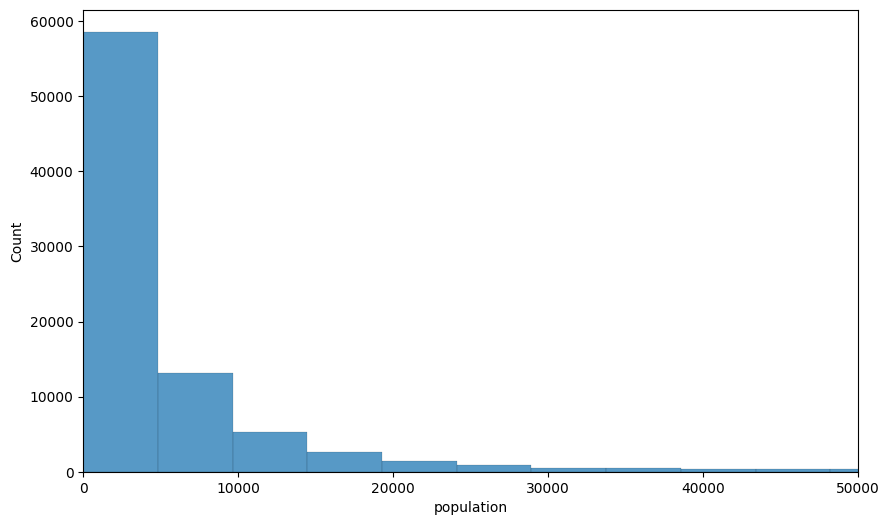

In [6]:
# check distribution of listings per population
plt.figure(figsize = (10,6))
sns.histplot(data = df1.groupby(['mun_istat', 'year']).agg({'population':'mean'}), x = 'population')
plt.xlim(0,50000)

Review with quantiles-like classes (more emirically defensible)

In [7]:
# create different classes of municipalities based on population. The two sources below provides too many classes. Lower classes are shrunk into two classes. 
# (https://finanzalocale.interno.gov.it/docum/studi/varie/200707varclass.html#:~:text=In%20dettaglio%2C%20i%20comuni%20risultano,abitanti%2C%20come%20di%20seguito%20descritto.
# https://www.rgs.mef.gov.it/_Documenti/VERSIONE-I/Selezione_normativa/D-Lgs-/DLgs18-08-2000_267.pdf_clean)

def classify_mun(pop):
    if pop < 3000:
        return "Small"      # many small municipalities
    elif pop < 10000:
        return "Medium"           # bulk of the dataset
    elif pop < 50000:
        return "Large"          # typical mid-size cities
    elif pop < 150000:
        return "Very large"           # larger cities
    else:
        return "Metropoly"      # major metropolitan areas


df_pop_2014 = df1.groupby(['mun_istat','year']).agg({'population':'mean'}).reset_index()

df_pop_2014 = df_pop_2014[df_pop_2014['year'] == 2014]

df_pop_2014['mun_class_pop'] = df_pop_2014['population'].apply(classify_mun)

df1 = pd.merge(df1, df_pop_2014[['mun_istat','mun_class_pop']], on = 'mun_istat', how = 'left')

df1['mun_class_pop'].value_counts()

mun_class_pop
Small         225837
Medium        177488
Large         118473
Very large     17503
Metropoly       4426
Name: count, dtype: int64

Log transform

In [8]:
# clear null values in population
df1 = df1.dropna()

In [9]:
# apply log transformation to typically skewed variables (population, income, surface, real GDP) - PURE ELASTICITY
df1['log_population'] = np.log(df1['population'] + 1)

df1['log_dwellings'] = np.log(df1['dwellings'] + 1)

log_var = [
    'median_income','real_gdp'
]

for col in log_var:
    df1['log_' + col] = np.log(df1[col])

Immigration and emigration ratios

In [10]:
# total number of immigrants, emigrants, and net movements (standardized per 100 inhabitants) - SEMI-ELASTICITY
df1['prov_immigration'] = ((df1['abroad_in'] + df1['nation_in']) / df1['population']) * 100

df1['prov_emigration'] = ((df1['abroad_out'] + df1['nation_out']) / df1['population']) * 100

df1['prov_net_movements'] = ((df1['prov_immigration'] - df1['prov_emigration']) / df1['population']) * 100

Pre / After -COVID dummy 

In [11]:
df1['covid'] = np.where(df1['year'] < 2020, 0, 1)

Tourism variables

In [12]:
# total number of hotel beds
hotel_col = [
    'five_stars_count',
    'four_stars_count',
    'three_stars_count',
    'two_stars_count',
    'one_stars_count'
]

df1['hotel_count'] = df1[hotel_col].sum(axis = 1).astype(int)

# drop hotel_col
df1 = df1.drop(columns = hotel_col)

# two variables are computed for a better overview of hotel presence in a municipality
# HOTEL PRESSURE ON TOURISM SECTOR - ratio between hotel beds (total beds - other accomodations bed) and total beds (per 100 beds) - LOG-LEVEL (SEMI-ELASTICITY)
df1['ratio_hotel_beds'] = np.where(df1['tot_beds'] == 0, 0, ((df1['tot_beds'] - df1['tot_acc_beds']) / df1['tot_beds']) * 100)

# HOTEL PRESSURE ON MUNICIPALITY - ratio between hotel beds and population (per 100 inhabitants) - LOG-LEVEL (SEMI-ELASTICITY)
df1['ratio_hotel_mun'] = ((df1['tot_beds'] - df1['tot_acc_beds']) / df1['population']) * 100

In [13]:
# three variables are computed for a better overview of holiday dwellings impact on the tourism sector and on municipalities
# STR PRESSURE ON TOURISM SECTOR - ratio between holiday dwellings bed and total beds (per 100 beds) - LOG-LEVEL (SEMI-ELASTICITY)
df1['ratio_str_beds'] = np.where(df1['tot_beds'] == 0, 0, (df1['holiday_dwelling_beds'] / df1['tot_beds']) * 100) 

# STR PRESSURE ON MUNICIPALITY (1)  - ratio of holiday dwellings and population (per 100 dwellings) - LOG-LEVEL (SEMI-ELASTICITY)
df1['ratio_str_mun'] = (df1['holiday_dwelling_count'] / df1['dwellings']) * 100

# STR PRESSURE ON MUNICIPALITY (2)  - ratio of holiday beds and population (per 100 inhabitants) - LOG-LEVEL (SEMI-ELASTICITY)
df1['ratio_str_mun_beds'] = (df1['holiday_dwelling_beds'] / df1['population']) * 100

In [14]:
# measure the ratio between total arrivals and population (per 100 inhabitants) - LOG-LEVEL (SEMI-ELASTICITY)
df1['ratio_arrivals'] = (df1['tot_arrivals'] / df1['population']) * 100

# measure the ratio between total foreigner arrivals and population (per 100 inhabitants) - LOG-LEVEL (SEMI-ELASTICITY)
df1['ratio_arrivals_foreigners'] = (df1['tot_arrivals_foreigners'] / df1['population']) * 100

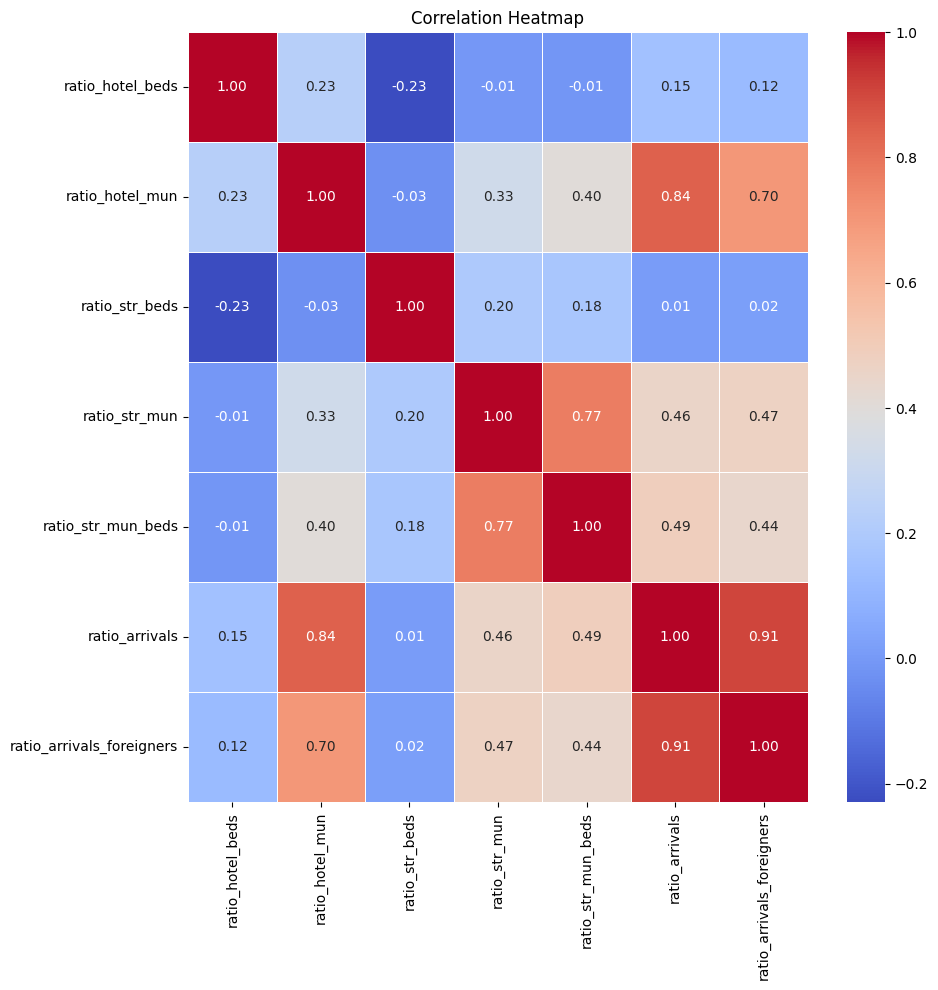

In [15]:
# correlation matrix
# Correlation matrix
var_corr = [
    'ratio_hotel_beds',
    'ratio_hotel_mun',
    'ratio_str_beds',
    'ratio_str_mun',
    'ratio_str_mun_beds',
    'ratio_arrivals',
    'ratio_arrivals_foreigners'
]

matrix = df1[var_corr].corr()

plt.figure(figsize=(10,10))
sns.heatmap(matrix, annot = True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Tourism index - VdW score

In [16]:
# compute Van der Waerden score as a tourist index - consider ratios
# define the function
def van_der_waerden_score(x):
    # create a rank
    ranks = x.rank(method='average')
    n = len(x)
    # define the score between 0 and 1
    score = (ranks / (n + 1))
    # compute the VdM score with CDF (For a given value x, what is the probability that a random variable is less than or equal to x?)
    vdW_scores = st.norm.ppf(score)
    return vdW_scores


vdw_var = [
    'ratio_hotel_mun',
    'ratio_str_mun',
    'ratio_str_mun_beds',
    'ratio_arrivals',
    'ratio_arrivals_foreigners'
]

for col in vdw_var:
    df1[col + '_vdw'] = van_der_waerden_score(df1[col])

# composite index based on VdW scores (average value)
df1['tourism_score'] = df1[[v + '_vdw' for v in vdw_var]].mean(axis=1)

In [17]:
# check minimum and maximum tourism score
print("Minimum tourism score: ", df1['tourism_score'].min())
print("Maximum tourism score: ", df1['tourism_score'].max())

Minimum tourism score:  -0.8487578965495701
Maximum tourism score:  3.411915013632954


Create tourism classes 

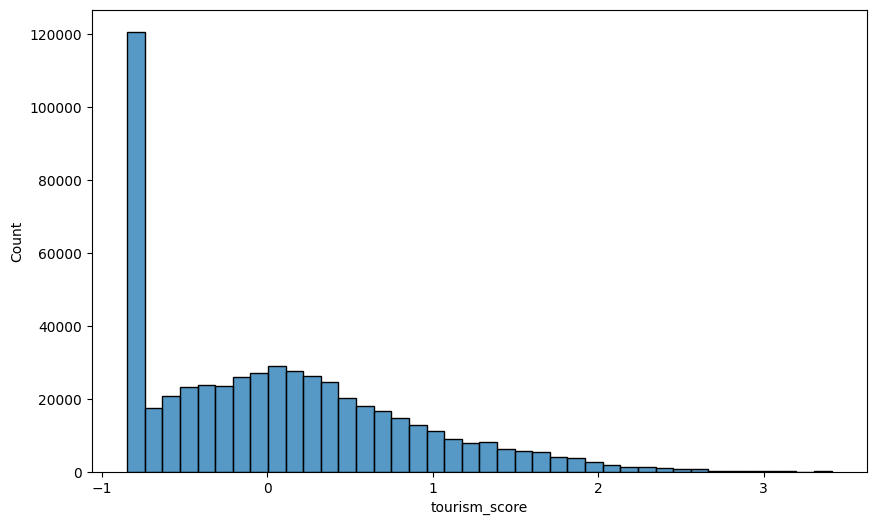

In [18]:
plt.figure(figsize=(10,6))
sns.histplot(data=df1, x='tourism_score', bins = 40)
plt.show()

There are many observations with a tourism score close to the minimum. In order not to bias the other classes (including minimum values in the quantiles would fill the lower classes with minimum tourism scores), municipalities with no tourism flow (0 ARRIVALS at year t) are grouped in a separate class ('Zero').

Two classes are computed: one from 2014 (start of the panel dataset) and one from 2024.

In [19]:
df1_2014 = df1[df1['year'] == 2014].copy()

# identify the minimum score in 2014
min_score = df1_2014['tourism_score'].min()

# separate minimum-score municipalities
mask_2014 = df1_2014['tot_arrivals'] == 0
df1_2014['tourism_class'] = None
df1_2014.loc[mask_2014, 'tourism_class'] = 'Zero'

# get the remaining scores
remaining_2014 = df1_2014.loc[~mask_2014, 'tourism_score']

# Define custom percentiles (must start at 0 and end at 1)
percentiles = [0, 0.60, 0.85, 1.00]

# Convert percentiles to score thresholds
quantile_edges = remaining_2014.quantile(percentiles).values

quantile_labels = ['Low', 'Moderate', 'High']

df1_2014.loc[~mask_2014, 'tourism_class'] = pd.cut(
    remaining_2014,
    bins=quantile_edges,
    include_lowest=True,
    labels=quantile_labels
)

# collapse 2014 classes to municipality level
tourism_class_2014 = (
    df1_2014[['mun_istat', 'tourism_class']]
    .drop_duplicates(subset='mun_istat')
)

# safely merge back
df1 = df1.merge(
    tourism_class_2014.rename(columns={'tourism_class': 'tourism_class_2014'}),
    on='mun_istat',
    how='left',
    suffixes=('', '_2014')
)

# check the distribution
print(df1['tourism_class_2014'].value_counts())

tourism_class_2014
Zero        259296
Low         170572
Moderate     71306
High         42553
Name: count, dtype: int64


In [20]:
df1_2024 = df1[df1['year'] == 2024].copy()

# identify the minimum score in 2024
min_score = df1_2024['tourism_score'].min()

# separate minimum-score municipalities
mask_2024 = df1_2024['tot_arrivals'] == 0
df1_2024['tourism_class'] = None
df1_2024.loc[mask_2024, 'tourism_class'] = 'Zero'

# get the remaining scores
remaining_2024 = df1_2024.loc[~mask_2024, 'tourism_score']

# Define custom percentiles (must start at 0 and end at 1)
percentiles = [0, 0.60, 0.85, 1.00]

# Convert percentiles to score thresholds
quantile_edges = remaining_2024.quantile(percentiles).values

quantile_labels = ['Low', 'Moderate', 'High']

df1_2024.loc[~mask_2024, 'tourism_class'] = pd.cut(
    remaining_2024,
    bins=quantile_edges,
    include_lowest=True,
    labels=quantile_labels
)

# collapse 2024 classes to municipality level
tourism_class_2024 = (
    df1_2024[['mun_istat', 'tourism_class']]
    .drop_duplicates(subset='mun_istat')
)

# safely merge back
df1 = df1.merge(
    tourism_class_2024.rename(columns={'tourism_class': 'tourism_class_2024'}),
    on='mun_istat',
    how='left',
    suffixes=('', '_2024')
)

# check the distribution
print(df1['tourism_class_2024'].value_counts())

tourism_class_2024
Low         234877
Zero        151495
Moderate     98490
High         58865
Name: count, dtype: int64


Order and select useful variables

In [21]:
#col = [
#    'mun_istat', 'year', 'covid', 'mun_name', 'mun_name_norm', 'region', 'prov', 'prov_istat', 'sector', 'type', 'condition', 'log_buy_min', 'log_buy_max', 'log_buy_avg', 
#    'log_population', 'mun_class_pop', 'log_median_income', 'dwellings', 'prov_immigration', 'prov_emigration', 'prov_net_movements', 'log_real_gdp',
#    'cpi', 'gini', 'unemployment', 'birth_rate', 'life','ratio_hotel_beds', 'ratio_hotel_mun', 'ratio_str_beds', 'ratio_str_mun', 'ratio_str_mun_beds', 
#    'ratio_arrivals', 'ratio_arrivals_foreigners', 'tourism_score', 'tourism_class_2014', 'tourism_class_2024', 'log_buy_avg_diff', 'log_population_diff', 
#    'log_median_income_diff'
#]

#df_clean = df_clean[col]

In [22]:
col = [
    'mun_istat', 'year', 'covid', 'mun_name', 'mun_name_norm', 'region', 'prov', 'prov_istat', 'sector', 'type', 'condition', 'log_buy_min', 'log_buy_max', 'log_buy_avg', 
    'population','log_population', 'mun_class_pop', 'reg_age_avg', 'over65', 'log_median_income', 'dwellings','log_dwellings', 'prov_immigration', 'prov_emigration', 'prov_net_movements', 'log_real_gdp', 'gdp_growth',
    'cpi', 'cpi_growth', 'homicides', 'gini', 'unemployment_prov', 'birth_rate', 'life','ratio_hotel_beds', 'ratio_hotel_mun', 'ratio_str_beds', 'ratio_str_mun', 'ratio_str_mun_beds', 
    'ratio_arrivals', 'ratio_arrivals_foreigners', 'tourism_score', 'tourism_class_2014', 'tourism_class_2024'
]

df1 = df1[col]

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543727 entries, 0 to 543726
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   mun_istat                  543727 non-null  object  
 1   year                       543727 non-null  int64   
 2   covid                      543727 non-null  int64   
 3   mun_name                   543727 non-null  object  
 4   mun_name_norm              543727 non-null  object  
 5   region                     543727 non-null  object  
 6   prov                       543727 non-null  object  
 7   prov_istat                 543727 non-null  object  
 8   sector                     543727 non-null  category
 9   type                       543727 non-null  object  
 10  condition                  543727 non-null  category
 11  log_buy_min                543727 non-null  float64 
 12  log_buy_max                543727 non-null  float64 
 13  log_buy_avg   

In [24]:
zero_pop = (df["population"] == 0).sum()

# Count negative values
neg_pop = (df["population"] < 0).sum()

zero_pop, neg_pop

(np.int64(37), np.int64(0))

In [25]:
df1.to_parquet('datasets/model_data.parquet', index = False)

df1.to_csv('datasets/model_data.csv', index = False)